In [1]:
import os
import glob

import numpy as np
import nibabel as nib
from nilearn import plotting, image

from glob import glob
from pyrsa.util.searchlight import get_volume_searchlight, get_searchlight_RDMs, evaluate_models_searchlight
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
#plt.style.use('seaborn-whitegrid')

/home/nima/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
base_dir = os.path.expanduser('~') + '/Desktop/study_forrest_rsa'
fmri_dir = base_dir + '/derivatives/fmriprep'
out_dir = base_dir + '/code/output'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [3]:
sub_test_list = ['%.2d' % i for i in range(1, 20)]
sub_train_list= ['%.2d' % i for i in range(21, 37)]
run_list = ['%.1d' % j for j in range(1, 9)]

In [7]:
def load_RDM(run_num, chunk_num, dimension, train=False):
    '''
    Load previously calculated RDMs. Return only the upper triangular index of an RMD. Delete the diagonal
    as suggested by Ritchie, Bracci and Op de Beeck (2017).
    '''
    beh_train_dir = base_dir + '/simi_matrices_train'
    beh_test_dir = base_dir + '/simi_matrices'
    
    # To-Do: include if statement to kick out chunks with > 50% NaN
    if train == False:
        data_dir = beh_test_dir
    else:
        data_dir = beh_train_dir
        
    rdm_file = data_dir + f'/run-{run_num}_dim-{dimension}_chunk-{chunk_num}.tsv'
    RDM = np.loadtxt(rdm_file, delimiter='\t')
    
    m = RDM.shape[0]
    r, c = np.triu_indices(m, 1)
    
    return RDM[r, c]

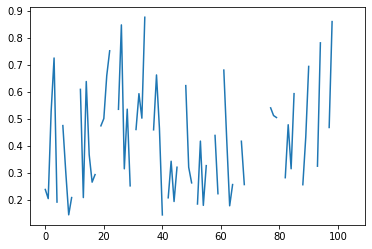

In [8]:
plt.plot(load_RDM(run_num='1', chunk_num=123, dimension='duration', train=True))

**Load fMRI data, apply whole brain searchlight and compute neural RDMs.**<br>
 - The 'kernel' is the measure / function / classifier that is applied to the searchlight data <br>

In [10]:
from brainiak.fcma.preprocessing import prepare_searchlight_mvpa_data
from brainiak import io
from shutil import copyfile

In [13]:
def load_fmri(sub_num, run_num, fmri_dir, chunk_num, hd_delay):
    '''
    Load subject and run specific fmriprep preprocessed and denoised BOLD and mask files. Combine both, 
    return masked image. Slice 4th dimension of an image according to timepoint of the movie segment, 
    incorporate 2 sec hemo-dynamic delay.
    '''
    func_file = out_dir + f'/sub-{sub_num}/sub-{sub_num}_run-{run_num}_cleaned.nii.gz
    mask_file = fmri_dir + f'/sub-{sub_num}/ses-movie/func/sub-{sub_num}_ses-movie_task-movie_run-{run_num}_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz'
    
    # get mask
    whole_brain_mask = nib.load(mask_file)
    whole_brain_mask = whole_brain_mask.get_data()
    coords = np.where(whole_brain_mask) # Where are the non zero values
    
    # load 4D data, get affine transformation
    func = nib.load(func_file)
    affine_mat = func.affine
    func = func.get_fdata()
    
    # chunk the data according to eye-RDM duration
    chunk_func = func[:, :, :, chunk_num + hd_delay:chunk_num + hd_delay + 1]
    
    return whole_brain_mask, func, chunk_func, affine_mat

In [16]:
mask, func_data, chunked_data, affine_mat = load_fmri(sub_num='01', run_num='1', fmri_dir=fmri_dir, chunk_num=1, hd_delay=2)
print('mask shape:', mask.shape)
print('functional shape:', func_data.shape)
print('chunked data shape:', chunked_data.shape)

<ipython-input-13-354971fc00ce>:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  whole_brain_mask = whole_brain_mask.get_data()


mask shape: (97, 115, 97)
functional shape: (97, 115, 97, 451)
chunked data shape: (97, 115, 97, 1)


In [17]:
affine_mat

array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])